In [ ]:
# default_exp geometry.meshed_geometry

# Create meshed geometry

> API details.

In [ ]:
#hide
from nbdev.showdoc import *
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
#export
import os

In [ ]:
#hide
import sys, subprocess

sys.path.append(os.path.join(os.getcwd(), '..'))

In [ ]:
#export
import numpy as np
import pygmsh
import meshio

from accelerate_simulations.geometry import AbstractGeometry

In [ ]:
#hide
box_size = (100, 100)
circle_radius = 10
n_circles = 4

In [ ]:
#hide
abstract_geometry = AbstractGeometry(n_circles, circle_radius, box_size, 42)
abstract_geometry.n_circles

4

In [ ]:
#export
def make_msh(output_path, abstract_geometry: AbstractGeometry, cl_coarse, cl_fine, verbose=False, path_to_tethex='~/tethex/build/tethex'):
    circle_centers, circle_radius, box_corner_coords = abstract_geometry.get_geom_info()

    geom = pygmsh.built_in.Geometry()

    point1 = geom.add_point([box_corner_coords[0][0], box_corner_coords[0][1], 0], cl_coarse)
    point2 = geom.add_point([box_corner_coords[1][0], box_corner_coords[1][1], 0], cl_coarse)
    point3 = geom.add_point([box_corner_coords[2][0], box_corner_coords[2][1], 0], cl_coarse)
    point4 = geom.add_point([box_corner_coords[3][0], box_corner_coords[3][1], 0], cl_coarse)

    line1 = geom.add_line(point1, point2)
    line2 = geom.add_line(point2, point3)
    line3 = geom.add_line(point3, point4)
    line4 = geom.add_line(point4, point1)

    circle_loops = []
    circle_surfaces = []
    for idx, circle_center in enumerate(circle_centers):
        pointc = geom.add_point([circle_center[0], circle_center[1], 0], cl_fine)
        points = geom.add_point([circle_center[0]+circle_radius, circle_center[1], 0], cl_fine)
        circle = geom.add_circle_arc(points, pointc, points)
        
        circle_loop = geom.add_line_loop([circle])
        surface = geom.add_plane_surface(circle_loop)
        
        circle_loops.append(circle_loop)
        circle_surfaces.append(surface)

    line_loop1 = geom.add_line_loop([line1, line2, line3, line4])
    surface1 = geom.add_plane_surface(line_loop1, circle_loops)

    geom.add_physical(surface1, label=2)
    geom.add_physical(circle_surfaces, label=1)
    
    geom.add_physical(line1, label=4)
    geom.add_physical(line2, label=5)
    geom.add_physical(line3, label=6)
    geom.add_physical(line4, label=3)
    
    mesh = pygmsh.generate_mesh(geom, dim=2, verbose=verbose,  geo_filename=f'{output_path}.geo')

    if verbose: print('[INFO] making triangular mesh ...')
    os.system(f'gmsh {output_path}.geo -2 -v {int(verbose)} -o {output_path}.msh')

    if verbose: print('[INFO] converting tringular to quad mesh ...')
    os.system(f'{path_to_tethex} {output_path}.msh {output_path}_hex.msh {int(verbose)}')

    os.system(f'rm {output_path}.geo {output_path}.msh')

    return mesh

In [ ]:
mesh = make_msh('../data/old/rectangle', abstract_geometry, cl_coarse=10, cl_fine=2, verbose=False, path_to_tethex='~/tethex/build/tethex')


geo file: ../data/old/rectangle.geo


In [ ]:
from scipy.spatial import Delaunay

mesh_delaunay = Delaunay(mesh.points[:, :2])
mesh_delaunay.simplices = np.array(mesh.cells[1].data)

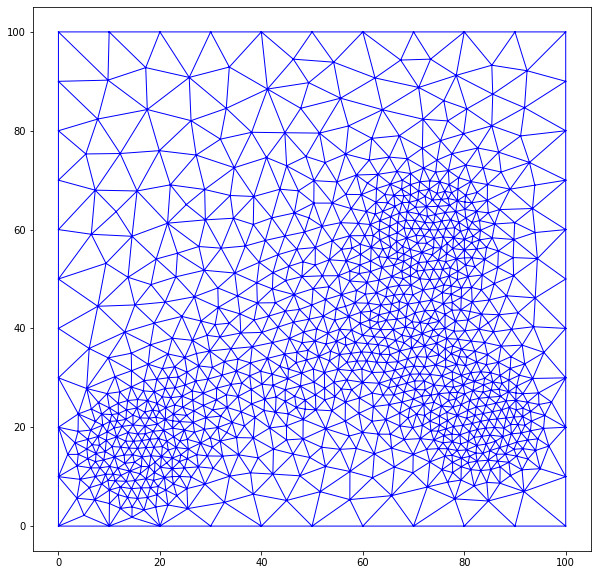

In [ ]:
plt.figure(figsize=(10, 10))
triangulation = matplotlib.tri.Triangulation(mesh_delaunay.points[:, 0], mesh_delaunay.points[:, 1], mesh_delaunay.simplices)
plt.triplot(triangulation, color='b', linewidth=1, alpha=1.0)
